# Bartlomiej Klimowski - Lingaro data science recruitment task.

**Overview** This notebook contains basic data exploration and evaluation of gradnient boosting and random forest models for house pricing prediction. Both models are tuned with randomized crossvalidation. Every step of analisys is described below.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
color = sns.color_palette()


from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.metrics import  mean_squared_error,r2_score




### Reading data from cvs source file

In [4]:
data_df = pd.read_csv('house.csv')
data_df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### Changing format of date to datetime and ordinal (new column)

In [3]:
data_df['date'] =pd.to_datetime(data_df['date'].str[:-7], format='%Y%m%d')
data_df['ordinal_date'] =data_df['date'].map(dt.datetime.toordinal)


### Checking datype of colums

In [4]:
dtype_df = data_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,16
1,datetime64[ns],1
2,float64,5


In [5]:
data_df.describe().round(1)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ordinal_date
count,2.161300e+04,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,...,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0
mean,4.580302e+09,540088.1,3.4,2.1,2079.9,15107.0,1.5,0.0,0.2,3.4,...,1788.4,291.5,1971.0,84.4,98077.9,47.6,-122.2,1986.6,12768.5,735535.2
std,2.876566e+09,367127.2,0.9,0.8,918.4,41420.5,0.5,0.1,0.8,0.7,...,828.1,442.6,29.4,401.7,53.5,0.1,0.1,685.4,27304.2,113.0
min,1.000102e+06,75000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,1.0,...,290.0,0.0,1900.0,0.0,98001.0,47.2,-122.5,399.0,651.0,735355.0
25%,2.123049e+09,321950.0,3.0,1.8,1427.0,5040.0,1.0,0.0,0.0,3.0,...,1190.0,0.0,1951.0,0.0,98033.0,47.5,-122.3,1490.0,5100.0,735436.0
50%,3.904930e+09,450000.0,3.0,2.2,1910.0,7618.0,1.5,0.0,0.0,3.0,...,1560.0,0.0,1975.0,0.0,98065.0,47.6,-122.2,1840.0,7620.0,735522.0
75%,7.308900e+09,645000.0,4.0,2.5,2550.0,10688.0,2.0,0.0,0.0,4.0,...,2210.0,560.0,1997.0,0.0,98118.0,47.7,-122.1,2360.0,10083.0,735646.0
max,9.900000e+09,7700000.0,33.0,8.0,13540.0,1651359.0,3.5,1.0,4.0,5.0,...,9410.0,4820.0,2015.0,2015.0,98199.0,47.8,-121.3,6210.0,871200.0,735745.0


### In search for missing values...

In [6]:
train_na = (data_df.isnull().sum() / len(data_df)) * 100
train_na

id               0.0
date             0.0
price            0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
zipcode          0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
ordinal_date     0.0
dtype: float64

### Exploration of target variable

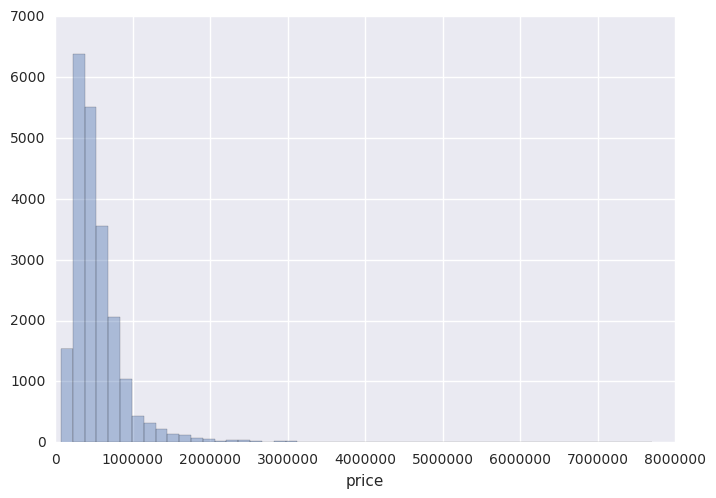

In [7]:
sns.distplot(data_df.price.values, kde=None)
plt.xlabel('price')

#### "Coarse grinding" prices

In [8]:
ulimit = np.percentile(data_df.price.values, 99.9)
llimit = np.percentile(data_df.price.values, 0.1)
data_df['price'].ix[data_df['price']>ulimit] = ulimit
data_df['price'].ix[data_df['price']<llimit] = llimit

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Our target variable is spread across few orders of magnitude, it's more suitable to work with log10 of this value.

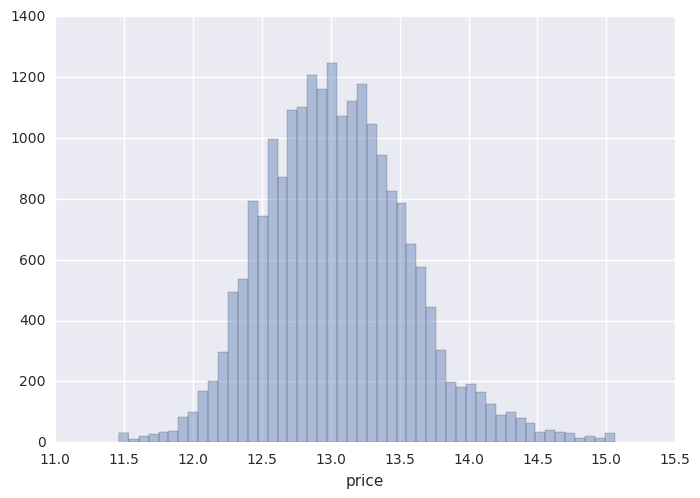

In [9]:
sns.distplot(np.log(data_df.price.values),  bins=50,kde=None)
plt.xlabel('price')
data_df['price_log'] = np.log1p(data_df['price'])

### Checking dependencies between date and price
There isn't any obvious trend in price along time. Only number of pricing differ over time.

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


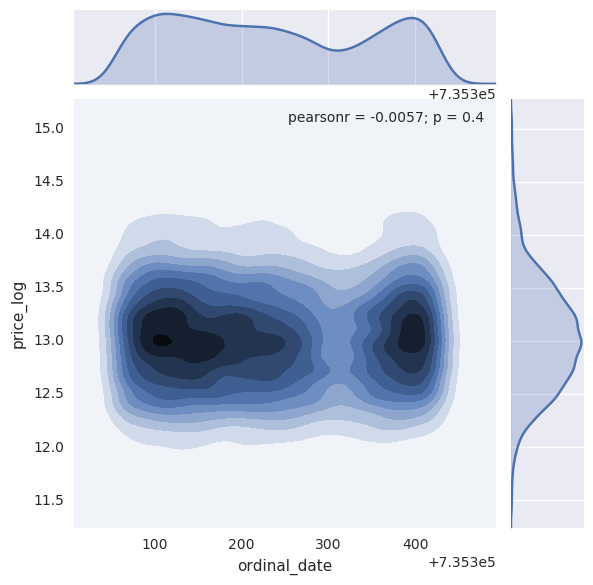

In [10]:
sns.jointplot(data_df['ordinal_date'], data_df['price_log'],kind="kde");

#### Dependency between position and price. Plot below shows house pricing with respect to placement. Unfortunetly readibility is rather horrible... we can do better.

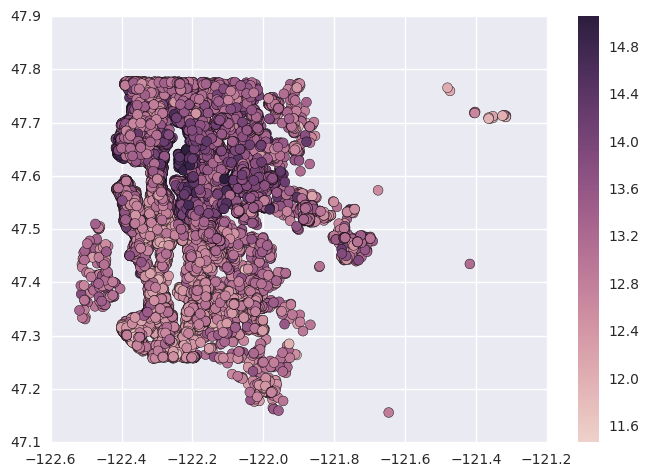

In [12]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(data_df['long'], data_df['lat'], c=data_df['price_log'], s=50, cmap=cmap)
f.colorbar(points)

In [13]:
round_df = data_df[['lat', 'long']].round(3)
position_df = round_df.groupby(['lat', 'long']).size().reset_index().rename(columns={0:'count'})

In [14]:
mean_price = np.zeros(tmp.shape[0])
for ii in range(0,tmp.shape[0]):
    mean_price[ii]=data_df.ix[round_df[round_df['long'] == position_df['long'][ii]][round_df['lat'] == position_df['lat'][ii]].index].price_log.mean()
position_df['mean_price'] = mean_price

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


#### Upgraded version of previous plot shows average price in location. We can see that properties on north are averagely more expensive.

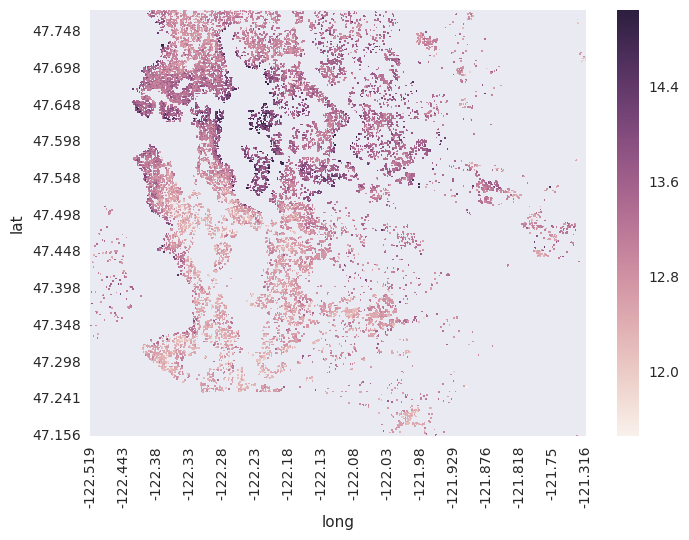

In [15]:
ax = sns.heatmap(position_df.pivot("lat","long", "mean_price"),xticklabels=50, yticklabels=50)
ax.invert_yaxis()

#### Actual landscape from google maps
![mapa](mapa.png)

#### Before evaluating our models, we need to split data into training and testing set.

In [16]:
data_X = data_df.drop(["id","date","price","price_log"],axis=1)
data_y = data_df['price_log']
X_train, X_test, Y_train, Y_test = train_test_split(data_X.values, data_y.values, test_size=0.20)

#### Below is commented section with randomized crossvalidation. Because it's time-consuming activity, I run it only few times and saved metaparameters values.

In [21]:
GBmodel = GradientBoostingRegressor()
# GB_param_dist = {"learning_rate": np.linspace(0.05, 0.15,5),
#               "max_depth": range(2, 7),
#               "min_samples_leaf": range(2, 7)}

# GBrandCV = RandomizedSearchCV(GBmodel, GB_param_dist, cv=5,n_iter=10, random_state=21)
# GBrandCV.fit(X_train,Y_train)
# GBrandCV.cv_results_ 

# print("Best GBmodel score:",round(GBrandCV.best_score_,2))
# print("Best GBmodel parameters:",GBrandCV.best_params_)

Best GBmodel score: 0.9

Best GBmodel parameters: {'learning_rate': 0.125, 'min_samples_leaf': 3, 'max_depth': 6}

In [22]:
RFmodel = RandomForestRegressor()
# RF_param_dist = {"n_estimators": range(2, 7),
#               "max_depth": [2,3,4, None],
#               "max_features": range(2, 7),
#               "min_samples_split": range(2, 7),
#               "min_samples_leaf": range(2, 7),
#               "bootstrap": [True, False],}

# RFrandCV = RandomizedSearchCV(RFmodel, RF_param_dist, cv=5,n_iter=10, random_state=21)
# RFrandCV.fit(X_train,Y_train)
# RFrandCV.cv_results_ 

# print("Best RFrandCV score:",round(RFrandCV.best_score_,2))
# print("Best RFrandCV parameters:",RFrandCV.best_params_)

Best RFrandCV score: 0.85 

Best RFrandCV parameters: {'min_samples_leaf': 5, 'bootstrap': False, 'n_estimators': 3, 'max_features': 4, 'max_depth': None, 'min_samples_split': 3}


#### Training models

In [23]:
GB_best_params = {'learning_rate': 0.125, 'min_samples_leaf': 3, 'max_depth': 6}
RF_best_params = {'min_samples_leaf': 5, 'bootstrap': False, 'n_estimators': 3, 'max_features': 4, 'max_depth': None, 'min_samples_split': 3}

GBmodel.set_params(**GB_best_params)
GBmodel.fit(data_X,data_y)

RFmodel.set_params(**RF_best_params)
RFmodel.fit(data_X,data_y)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Features importance

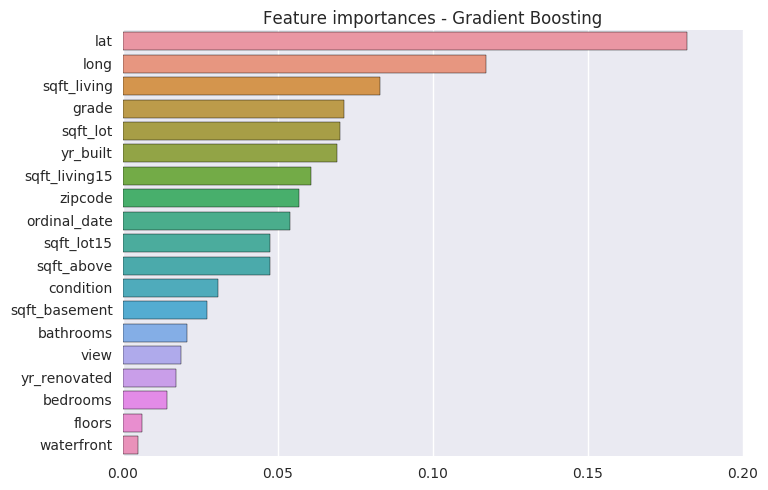

In [26]:
importances = GBmodel.feature_importances_
indices = np.argsort(importances)[::-1]


sns.barplot(importances[indices][:20],data_X.columns[indices[:20]].values)
plt.title("Feature importances - Gradient Boosting")

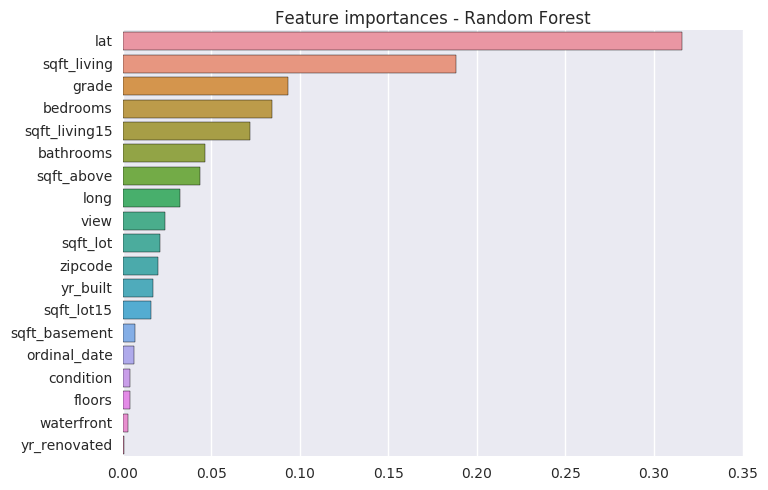

In [27]:
importances = RFmodel.feature_importances_
indices = np.argsort(importances)[::-1]

sns.barplot(importances[indices][:20],data_X.columns[indices[:20]].values)
plt.title("Feature importances - Random Forest")

In [28]:
print("Mean squared error GBmodel",round(mean_squared_error(Y_test,GBmodel.predict(X_test)),3))
print("R2 score GBmodel:",round(r2_score(Y_test,GBmodel.predict(X_test)),2), "\n")

print("Mean squared error RFmodel",round(mean_squared_error(Y_test,RFmodel.predict(X_test)),3))
print("R2 score RFmodel:",round(r2_score(Y_test,RFmodel.predict(X_test)),2))

Mean squared error GBmodel 0.016
R2 score GBmodel: 0.94 

Mean squared error RFmodel 0.014
R2 score RFmodel: 0.95


**Summary** Both evalueted models have similar, rather good efficency. According to features importance position of house is very influential part of pricing. Incorporation of some kind placement classification maybe good idea for further model improvement.